In [329]:
import numpy as np
import scipy
from scipy import signal
from scipy.interpolate import interp1d
from scipy.signal import butter, filtfilt
import h5py
import json

%matplotlib inline
import matplotlib
import matplotlib.pyplot as plt
import matplotlib.mlab as mlab


plt.rcParams['figure.figsize'] = [5, 3]
plt.rcParams['lines.linewidth'] = .75

! pip install -q gwpy

from gwpy.timeseries import TimeSeries

! pip install -q lalsuite

import lalsimulation as lalsim
from lal import MSUN_SI, PC_SI

In [324]:
def whiten(strain, interp_psd, dt, phase_shift=0, time_shift=0):
    """Whitens strain data given the psd and sample rate, also applying a phase
    shift and time shift.

    Args:
        strain (ndarray): strain data
        interp_psd (interpolating function): function to take in freqs and output 
            the average power at that freq 
        dt (float): sample time interval of data
        phase_shift (float, optional): phase shift to apply to whitened data
        time_shift (float, optional): time shift to apply to whitened data (s)
    
    Returns:
        ndarray: array of whitened strain data
    """
    Nt = len(strain)
    # take the fourier transform of the data
    freqs = np.fft.rfftfreq(Nt, dt)

    # whitening: transform to freq domain, divide by square root of psd, then
    # transform back, taking care to get normalization right.
    hf = np.fft.rfft(strain)
    
    # apply time and phase shift
    hf = hf * np.exp(-1.j * 2 * np.pi * time_shift * freqs - 1.j * phase_shift)
    norm = 1./np.sqrt(1./(dt*2))
    white_hf = hf / np.sqrt(interp_psd(freqs)) * norm
    white_ht = np.fft.irfft(white_hf, n=Nt)
    return white_ht

def bandpass(strain, fband, fs):
    """Bandpasses strain data using a butterworth filter.
    
    Args:
        strain (ndarray): strain data to bandpass
        fband (ndarray): low and high-pass filter values to use
        fs (float): sample rate of data
    
    Returns:
        ndarray: array of bandpassed strain data
    """
    bb, ab = butter(4, [fband[0]*2./fs, fband[1]*2./fs], btype='band')
    normalization = np.sqrt((fband[1]-fband[0])/(fs/2))
    strain_bp = filtfilt(bb, ab, strain) / normalization
    return strain_bp

def matched_filter(template, data, time, data_psd, fs,alph):
    """Runs the matched filter calculation given a specific real template, strain
    data, time, psd, and sample rate. Finds the offset and phase to maximize
    SNR, as well as effective distance and horizon

    Args:
        template (ndarray): real part of initial template corresponding to event
        data (ndarray): strain data near event
        time (ndarray): time near event
        data_psd (interpolating function): psd of strain data around event
        fs (float): sample rate of data
    
    Returns:
        float: maximum SNR value obtained
        float: time of maximum SNR value
        float: effective distance found
        float: horizon found
        float: template phase which maximizes SNR
        float: template offset which maximizes SNR
    """

    # get the fourier frequencies of data for when we fft (for dividing by psd)
    datafreq = np.fft.fftfreq(template.size)*fs
    df = np.abs(datafreq[1] - datafreq[0])
    # for taking the fft of our template and data
    dwindow = signal.tukey(template.size, alpha=alph)
    # compute the template and data ffts.
    template_fft = np.fft.fft(template*dwindow) / fs
    data_fft = np.fft.fft(data*dwindow) / fs

    # use the larger psd of the data calculated earlier for a better calculation
    power_vec = list(map(data_psd, np.abs(datafreq)))

    # -- Zero out negative frequencies
    negindx = np.where(datafreq<0)
    data_fft[negindx] = 0

    # -- Calculate the matched filter output in the time domain: Multiply
    # the Fourier Space template and data, and divide by the noise power in
    # each frequency bin.  Taking the Inverse Fourier Transform (IFFT) of
    # the filter output puts it back in the time domain, so the result will
    # be plotted as a function of time off-set between the template and the
    # data:
    optimal = data_fft * template_fft.conjugate() / power_vec  
    optimal_time = 4 * np.fft.ifft(optimal) * fs

    # -- Normalize the matched filter output: Normalize the matched filter
    # output so that we expect an average value of 1 at times of just noise.  Then,
    # the peak of the matched filter output will tell us the
    # signal-to-noise ratio (SNR) of the signal.
    sigmasq = 2 * (template_fft * template_fft.conjugate() / power_vec).sum() * df
    sigma = np.sqrt(np.abs(sigmasq))
    SNR_complex = optimal_time/sigma

    # shift the SNR vector by the template length so that the peak is at
    # the end of the template
    peaksample = int(data.size / 2)  # location of peak in the template
    SNR_complex = np.roll(SNR_complex,peaksample)
    SNR = abs(SNR_complex)

    # find the time and SNR value at maximum:
    indmax = np.argmax(SNR)
    timemax = time[indmax]
    SNRmax = SNR[indmax]

    # Calculate the effective distance
    d_eff = sigma / SNRmax
    # -- Calculate optimal horizon distnace
    horizon = sigma/8

    # Extract time offset and phase at peak
    phase = -np.angle(SNR_complex[indmax])
    offset = (indmax-peaksample)

    return SNRmax, timemax, d_eff, horizon, phase, offset

def get_shifted_data(template_p, strain, time, strain_whiten,
                     strain_whitenbp, fband, filter_data, data_psd,dt):
    """Obtains data shifts of templates and residual data after having found the
    best fit phase and offsets for the template.
    
    Args:
        template_p (ndarray): real (plus-polarization) part of template
        strain (ndarray): strain data
        time (ndarray): time
        strain_whiten (ndarray): whitened strain data
        strain_whitenbp (ndarray): whitened and bandpassed strain data
        fband (list): low and high pass filters for the template bandpass 
        filter_data (dict): dictionary containing phase, offset, d_eff values 
            for given matched filter calculation
        data_psd (interpolating function): function which outputs a power value
            for a given data frequency 

    Returns:
        ndarray: whitened, bandpassed, phaseshifted and offset template
        ndarray: phaseshifted and offset residual data
        ndarray: whitened, phaseshifted and offset residual data
        ndarray: whitened, bandpassed, phaseshifted and offset residual data
    """
    d_eff = filter_data['d_eff']
    phase = filter_data['phase']
    offset = filter_data['offset']

    # apply time and phase shift to template- we'll do this in the freq domain
    Nt = len(template_p)
    freqs = np.fft.rfftfreq(Nt, dt)
    # apply the fft, also scaling initial amplitude
    hf = np.fft.rfft(template_p / d_eff)
    # apply phase shift, time offset
    hf = hf * np.exp(-1.j * 2 * np.pi * (offset * dt) * freqs - 1.j * phase)
    # transform back
    template_shifted = np.real(np.fft.irfft(hf, n=Nt))

    # whiten and bandpass template_p for plotting- also applying phase shift,
    # amplitude scale
    template_whitened = whiten(template_p / d_eff, data_psd, dt,
                               phase_shift=phase, time_shift=(offset * dt))
    template_match = bandpass(template_whitened, fband, 1. / dt)

    # save the residual for later
    resid_data_whiten= strain_whiten - template_whitened
    resid_data_whitenbp = strain_whitenbp - template_match

    # save the nonbandpassed, nonwhitened residual as well
    resid_data = strain - template_shifted
    return template_match, resid_data, resid_data_whiten, resid_data_whitenbp

def alphiser(alph):
    time_center = 1167559936
    delt = 5

    strain_H1 = TimeSeries.fetch_open_data('H1', time_center - delt, time_center + delt)
    strain_L1 = TimeSeries.fetch_open_data('L1', time_center - delt, time_center + delt)

    time = np.array(strain_H1.times)
    fs = int(strain_H1.sample_rate.value)
    dt = strain_H1.dt.value

    strain_H1 = np.array(strain_H1)
    strain_L1 = np.array(strain_L1)

    #plt.plot(time, strain_L1, 'blue', alpha=0.8, label="L1")
    #plt.plot(time, strain_H1, 'red', alpha=0.8, label="H1")
    #plt.legend(loc="best");
    
    NFFT = 4*fs
    NOVL = 1*NFFT/2
    psd_window = scipy.signal.tukey(NFFT, alpha= alph)

    ##################################WELCH################################################
    Pxx_H1, freqs = mlab.psd(strain_H1, Fs=fs, NFFT=NFFT, window=psd_window, noverlap=NOVL)
    Pxx_L1, freqs = mlab.psd(strain_L1, Fs=fs, NFFT=NFFT, window=psd_window, noverlap=NOVL)
    #We interpolate these PSDs for the whitening stage
    psd_H1 = interp1d(freqs,Pxx_H1)
    psd_L1 = interp1d(freqs,Pxx_L1)

    ##################################NON-WELCH###########################################
    short_indxt_away = np.where((time >= time_center - 2) & (time < time_center + 2))
    ##################################TUKEY
    tukey_Pxx_H1, tukey_freqs = mlab.psd(strain_H1[short_indxt_away], Fs=fs, NFFT=NFFT, window=psd_window)
    tukey_Pxx_L1, tukey_freqs = mlab.psd(strain_L1[short_indxt_away], Fs=fs, NFFT=NFFT, window=psd_window)
    ##################################NO-WINDOW
    nowin_Pxx_H1, nowin_freqs = mlab.psd(strain_H1[short_indxt_away], Fs=fs, NFFT=NFFT, window=mlab.window_none)
    nowin_Pxx_L1, nowin_freqs = mlab.psd(strain_L1[short_indxt_away], Fs=fs, NFFT=NFFT, window=mlab.window_none)

    ##################################PLOTTING H1##########################################
    #plt.figure(figsize=(8, 5))
    #plt.xscale('log', basex=2)
    #plt.yscale('log', basey=10)
    #plt.plot(nowin_freqs, nowin_Pxx_H1,'purple',label= 'No Window', alpha=.6, linewidth=1)
    #plt.plot(tukey_freqs, tukey_Pxx_H1 ,'green',label='Tukey Window', alpha=.6, linewidth=1)
    #plt.plot(freqs, Pxx_H1,'black',label='Welch Average', alpha=.6, linewidth=1)

    inverse_square = np.array(list(map(lambda f: 1 / (f**2), nowin_freqs[1:])))

    scale_index = 500
    scale = nowin_Pxx_H1[scale_index]  / inverse_square[scale_index]
    #plt.plot(nowin_freqs[1:], inverse_square * scale,'red', label= r'$1 / f^2$', alpha=.8, linewidth=1)

    #plt.axis([10, 1000, 1e-48, 1e-41])
    #plt.ylabel('Sn(t)')
    #plt.xlabel('Freq (Hz)')
    #plt.legend(loc='upper center')
    #plt.title('LIGO PSD data near ' + str(time_center) + ' at H1')
    #plt.show()

    ################################PLOTTING L1############################################

    #plt.figure(figsize=(8, 5))
    #plt.xscale('log', basex=2)
    #plt.yscale('log', basey=10)
    #plt.plot(nowin_freqs, nowin_Pxx_L1,'purple',label= 'No Window', alpha=.6, linewidth=1)
    #plt.plot(tukey_freqs, tukey_Pxx_L1 ,'green',label='Tukey Window', alpha=.6, linewidth=1)
    #plt.plot(freqs, Pxx_L1,'black',label='Welch Average', alpha=.6, linewidth=1)

    inverse_square = np.array(list(map(lambda f: 1 / (f**2), nowin_freqs[1:])))

    scale_index = 500
    scale = nowin_Pxx_L1[scale_index]  / inverse_square[scale_index]
    #plt.plot(nowin_freqs[1:], inverse_square * scale,'red', label= r'$1 / f^2$', alpha=.8, linewidth=1)

    #plt.axis([10, 1000, 1e-48, 1e-41])
    #plt.ylabel('Sn(t)')
    #plt.xlabel('Freq (Hz)')
    #plt.legend(loc='upper center')
    #plt.title('LIGO PSD data near ' + str(time_center) + ' at L1')
    #plt.show()
    
    fband = [30.0, 350.0]

    # create our 4 second data window
    window_len = 4*fs
    dwindow = scipy.signal.tukey(window_len, alpha= alph)

    ##########################PLOTTING H1#################################
    #plt.figure(figsize=(8, 8))
    #plt.subplot(4, 1, 1)
    indxt = np.where((time >= time_center - 2) & (time < time_center + 2))
    #plt.xlim([-2, 2])
    #plt.plot(time[indxt] - time_center, strain_H1[indxt], 'red', label='Hanford Data', linewidth=.5, alpha=.5)
    #plt.plot(time[indxt] - time_center, strain_L1[indxt], 'blue', label='Livingston Data', linewidth=.5, alpha=.5)
    #plt.legend()

    # plot windowed data
    #plt.subplot(4, 1, 2)
    strain_windowed_H1 = dwindow * strain_H1[indxt]
    strain_windowed_L1 = dwindow * strain_L1[indxt]
    #plt.xlim([-2, 2])
    #plt.plot(time[indxt] - time_center, strain_windowed_H1, 'red', label='Windowed Data, H1', linewidth=.5, alpha=.5)
    #plt.plot(time[indxt] - time_center, strain_windowed_L1, 'blue', label='Windowed Data, L1', linewidth=.5, alpha=.5)
    #plt.legend()

    # plot whitened data
    #plt.subplot(4, 1, 3)
    strain_whitened_H1 = whiten(strain_windowed_H1, psd_H1, dt)
    strain_whitened_L1 = whiten(strain_windowed_L1, psd_L1, dt)
    #plt.plot(time[indxt] - time_center, strain_whitened_H1, 'red', label='Whitened Data, H1', linewidth=.5, alpha=.5)
    #plt.plot(time[indxt] - time_center, strain_whitened_L1, 'blue', label='Whitened Data, L1', linewidth=.5, alpha=.5)
    #plt.legend()

    # plot bandpassed data
    #plt.subplot(4, 1, 4)
    strain_bp_H1 = bandpass(strain_whitened_H1, fband, fs)
    strain_bp_L1 = bandpass(strain_whitened_L1, fband, fs)
    #plt.xlim([-2, 2])
    #plt.plot(time[indxt] - time_center, strain_bp_H1, 'red', label='Bandpassed Data, H1', linewidth=.5, alpha=.5)
    #plt.plot(time[indxt] - time_center, strain_bp_L1, 'blue', label='Bandpassed Data, L1', linewidth=.5, alpha=.5)

    #plt.legend()
    #plt.yticks([-6, -3, 0, 3, 6, 9])
    #plt.tight_layout()
    #plt.xlim([-2, 2])
    #plt.ylim([-8, 8])
    #plt.show()
    
    dataH = strain_H1[indxt]
    dataL = strain_L1[indxt]

    #plt.figure(figsize=(8, 5))
    tukey_window_H = signal.tukey(dataH.size, alpha=alph),
    tukey_window_L = signal.tukey(dataL.size, alpha=alph),
    labelsH = ['Tukey window, H', 'No window, H']
    labelsL = ['Tukey window, L', 'No window, L']
    colorsH = ['yellow', 'blue']
    colorsL = ['yellow', 'red']

    # apply each window and find phases of the fft
    for i, dwindow in enumerate([tukey_window_H, 1]):
        data_fft_H = np.fft.rfft((dataH * dwindow).flatten()) * dt
        datafreq_H = np.fft.rfftfreq(dataH.size) / dt
        phases_H = np.angle(data_fft_H)
        # convert angles to range (0, 2 pi)
        phases_H = (phases_H + 2 * np.pi) % (2 * np.pi)
        #plt.plot(datafreq_H, phases_H, '.', label=labelsH[i], color=colorsH[i], markersize=1)

    for i, dwindow in enumerate([tukey_window_H, 1]):
        data_fft_L = np.fft.rfft((dataL * dwindow).flatten()) * dt
        datafreq_L = np.fft.rfftfreq(dataL.size) / dt
        phases_L = np.angle(data_fft_L)
        # convert angles to range (0, 2 pi)
        phases_L = (phases_L + 2 * np.pi) % (2 * np.pi)
        #plt.plot(datafreq_L, phases_L, '.', label=labelsL[i], color=colorsL[i], markersize=1)

    #plt.xlim([30, 350])
    #plt.ylim([0, 6])
    #plt.xlabel('f(Hz)')
    #plt.ylabel('Phase')
    #plt.legend(loc='upper right', fontsize=7);
    
    mass_1=31.2*MSUN_SI
    mass_2=19.4*MSUN_SI
    # The distance, in meters
    luminosity_distance=880*PC_SI * 10**6

    # Setting everything else to 0 or default values:
    S1x=0.
    S1y=0.
    S1z=0.
    S2x=0.
    S2y=0.
    S2z=0.
    iota=0.0
    phase=0.0
    minimum_frequency=20.
    f_ref=100.
    approx = lalsim.GetApproximantFromString('SEOBNRv4')

    h_plus, _ = lalsim.SimInspiralChooseTDWaveform(mass_1, mass_2, S1x, S1y, S1z, S2x, S2y, S2z, luminosity_distance, iota,phase, 0.0, 0.0, 0.0, 1/16384.0, minimum_frequency,f_ref, None, approx)
    
    fig_template = h_plus.data.data

    # Downsample this data to 4096 Hz
    fig_template = scipy.signal.resample(fig_template, int(len(fig_template)/4) )

    # apply a Tukey window to taper the ends of the template
    taper_window = signal.tukey(len(fig_template), alpha=alph)
    fig_template_tapered = fig_template * taper_window
    
    # -- Plot template before and after tapering
    template_time = np.arange(0.25, 0.25+len(fig_template_tapered)*dt,dt)
    #plt.plot(template_time, fig_template, label='Before Taper')
    #plt.plot(template_time, fig_template_tapered, label='Tapered')
    #plt.xlabel('t(s)')
    #plt.legend()

    # Now we need to pad this with 0s to make it the same amount of time as the data
    halfdatalen = int(16*fs)
    begin_add = halfdatalen - len(fig_template_tapered)

    # add last 2048 seconds
    fig_template_tapered = np.append(fig_template_tapered, (halfdatalen * [0]))
    # add beginning- almost 2048 seconds
    fig_template_tapered = np.append((int(begin_add) * [0]), fig_template_tapered)
    
    template_p = fig_template_tapered

    # these specific values are defined in the paper
    fband = [35.0, 350.0]

    # Getting a more manageable 32s. of data:
    strain_H1 = TimeSeries.fetch_open_data('H1', time_center - 16, time_center + 16)
    strain_L1 = TimeSeries.fetch_open_data('L1', time_center - 16, time_center + 16)
    time = np.array(strain_H1.times)
    strain_H1 = np.array(strain_H1)
    strain_L1 = np.array(strain_L1)

    strain_whitened_H1 = whiten(strain_H1, psd_H1, dt)
    strain_whitened_L1 = whiten(strain_L1, psd_L1, dt)
    strain_bp_H1 = bandpass(strain_whitened_H1, fband, fs)
    strain_bp_L1 = bandpass(strain_whitened_L1, fband, fs)

    t_amount = 4

    filter_data = {'H1': {}, 'L1': {}}

    # amount of data we want to calculate matched filter SNR over- up to 32s
    data_time_window = time[len(time) - 1] - time[0] - (32 - t_amount)

    time_filter_window = np.where((time <= time_center + data_time_window * .5) &
                                  (time >= time_center - data_time_window * .5))
    time_filtered = time[time_filter_window]
    template_p = template_p[time_filter_window]

    strain_whitened_H1 = strain_whitened_H1[time_filter_window]
    strain_whitened_L1 = strain_whitened_L1[time_filter_window]
    strain_bp_H1 = strain_bp_H1[time_filter_window]
    strain_bp_L1 = strain_bp_L1[time_filter_window]
    strain_H1_4 = strain_H1[time_filter_window]
    strain_L1_4 = strain_L1[time_filter_window]

    # define the template using only the plus polarization
    template = template_p

    # save the time for later
    filter_data['time'] = time_filtered

    # find the best fit phase, offset, d_eff, horizon
    #SNRmax_H1, timemax_H1, d_eff_H1, horizon_H1, phase_H1, offset_H1 = matched_filter(template, strain_H1_4, time_filtered, psd_H1, fs,alph)
    SNRmax, timemax, d_eff, horizon, phase, offset = matched_filter(template, strain_L1_4, time_filtered, psd_L1, fs,alph)

    # save these vals for later
    filter_data['SNR'] = SNRmax
    filter_data['d_eff'] = d_eff
    filter_data['phase'] = phase
    filter_data['offset'] = offset

    #print("The phase offset is {0:.3f} radians".format(phase))
    print('Maximum at {0:.4f} with SNR = {1:.1f}, ' 
          .format(timemax, SNRmax))

    # get residuals and whitened data/template
    template_wbp, resid_data, resid_data_w, resid_data_wbp = get_shifted_data(template_p, strain_L1_4, time_filtered, strain_whitened_L1,strain_bp_L1, fband, filter_data, psd_L1,dt)

    filter_data['residual'] = resid_data
    filter_data['residual_whiten'] = resid_data_w
    filter_data['residual_whitenbp'] = resid_data_wbp
    
    #fig, axes = plt.subplots(2, 1, figsize=(8, 8), sharex=True)

    # plot whitened, phase and time shifted templates, data, residuals
    #ax = axes[0]
    #ax.plot(time_filtered - time_center, strain_bp_H1, 'b',
            #label='data')
    #ax.plot(time_filtered - time_center, template_wbp, 'r',
            #label='model')
    #ax.set_ylim([-8, 8])
    #ax.legend(loc='upper left')

    #ax = axes[1]
    #ax.plot(time_filtered - time_center, resid_data_wbp, 'k', 
            #label='residual')
    #ax.set_ylim([-4, 4])
    #ax.legend(loc='upper left')
    #plt.xlim([.45, .65])
    #plt.xlabel('Time since {0:.4f}'.format(time_center))
    print('Done it for alpha=%.5f' % alph)
    return (time_filtered-time_center), strain_bp_L1, strain_bp_H1, template_wbp, SNRmax

In [330]:
N=20
time=[]
strainL=[]
strainH=[]
model=[]
SNR=[]
alphas=np.linspace(0,0.1,51)

for i in range(51):
    answer=alphiser(alphas[i])
    time.append(answer[0])
    strainL.append(answer[1])
    strainH.append(answer[2])
    model.append(answer[3])
    SNR.append(answer[4])

Maximum at 1167559934.0952 with SNR = 11.2, 
Done it for alpha=0.00000
Maximum at 1167559934.0901 with SNR = 13.1, 
Done it for alpha=0.00200
Maximum at 1167559934.0867 with SNR = 12.9, 
Done it for alpha=0.00400
Maximum at 1167559934.0828 with SNR = 11.1, 
Done it for alpha=0.00600
Maximum at 1167559934.0793 with SNR = 13.1, 
Done it for alpha=0.00800
Maximum at 1167559934.0767 with SNR = 12.0, 
Done it for alpha=0.01000
Maximum at 1167559934.0728 with SNR = 11.1, 
Done it for alpha=0.01200
Maximum at 1167559934.0693 with SNR = 10.1, 
Done it for alpha=0.01400
Maximum at 1167559934.0674 with SNR = 9.3, 
Done it for alpha=0.01600
Maximum at 1167559934.0654 with SNR = 11.5, 
Done it for alpha=0.01800
Maximum at 1167559934.0610 with SNR = 10.5, 
Done it for alpha=0.02000
Maximum at 1167559934.0581 with SNR = 9.9, 
Done it for alpha=0.02200
Maximum at 1167559934.0559 with SNR = 9.0, 
Done it for alpha=0.02400
Maximum at 1167559934.0530 with SNR = 9.6, 
Done it for alpha=0.02600
Maximum at

<module 'time' (built-in)>

/cvmfs/ligo-containers.opensciencegrid.org/lscsoft/conda/latest/envs/ligo-py37/lib/python3.7/site-packages/ipykernel_launcher.py:7: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
  import sys


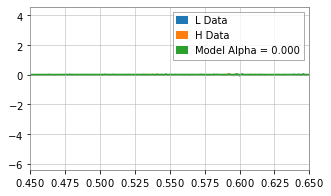

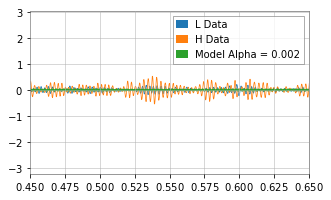

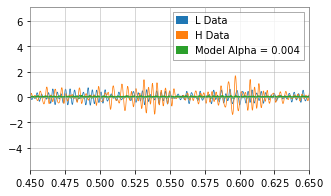

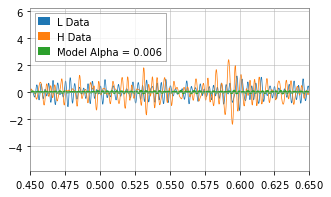

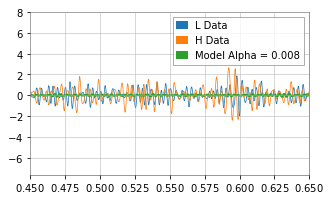

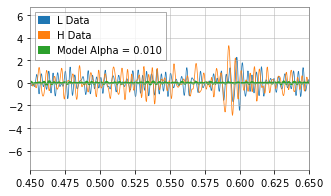

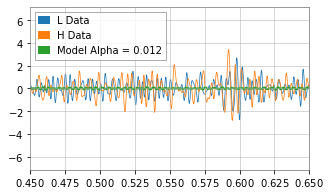

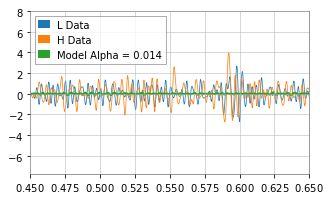

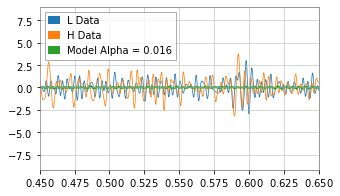

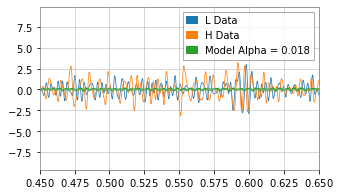

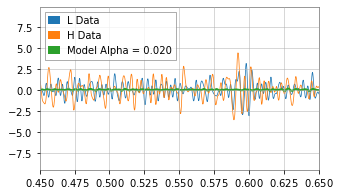

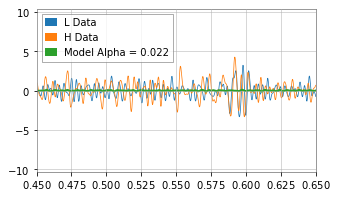

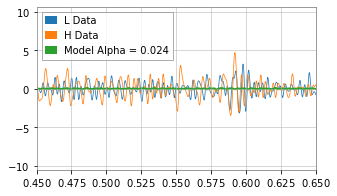

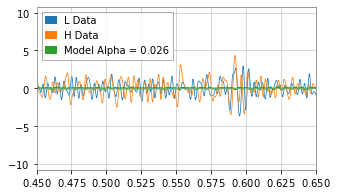

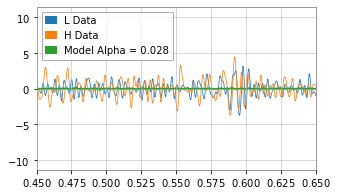

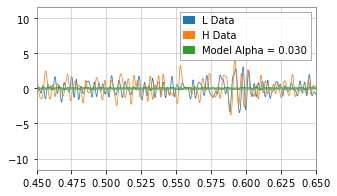

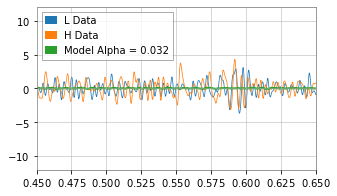

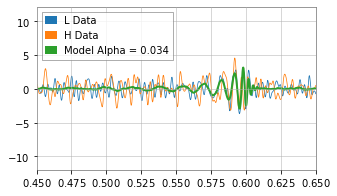

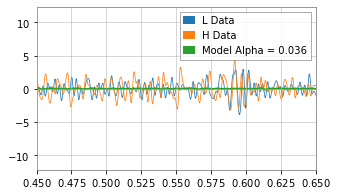

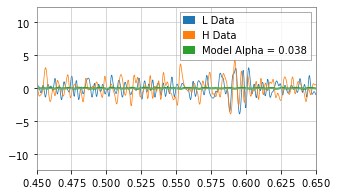

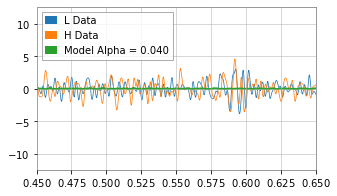

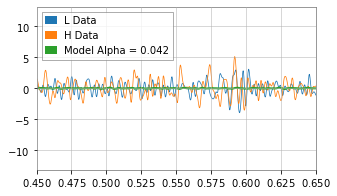

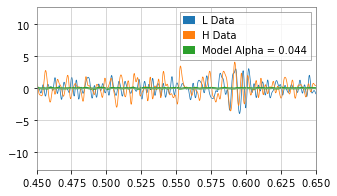

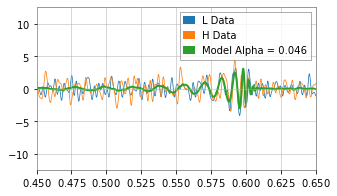

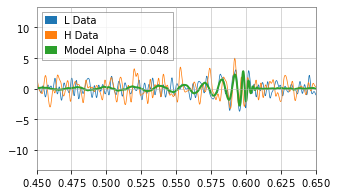

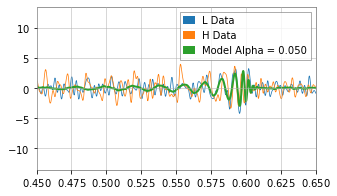

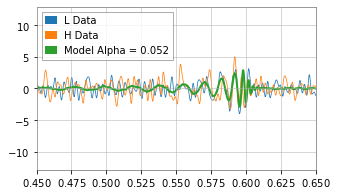

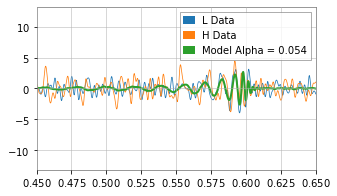

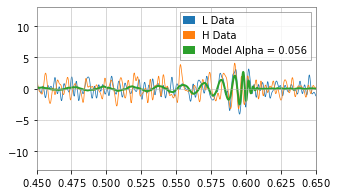

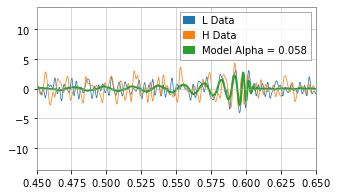

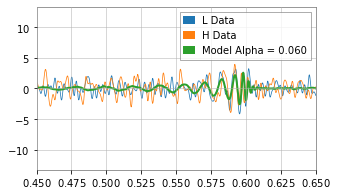

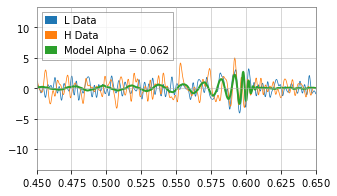

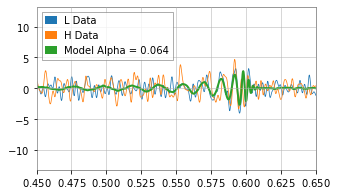

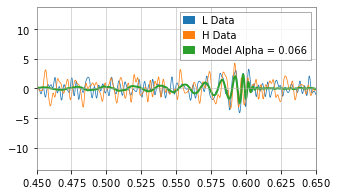

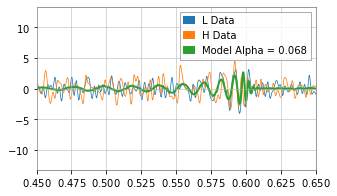

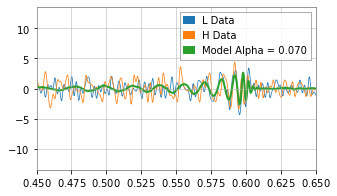

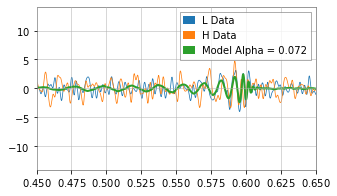

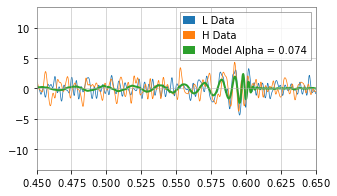

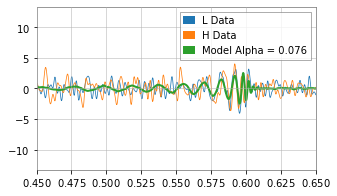

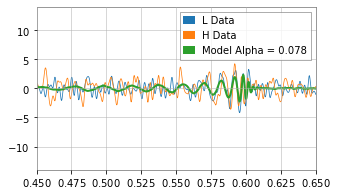

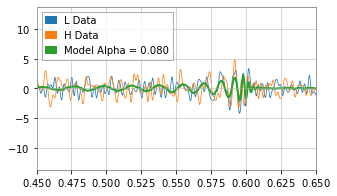

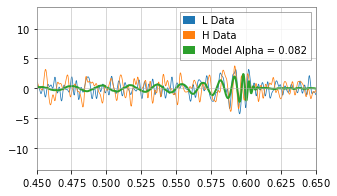

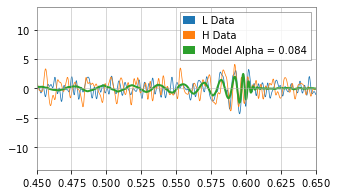

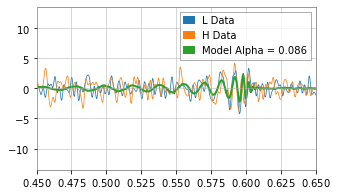

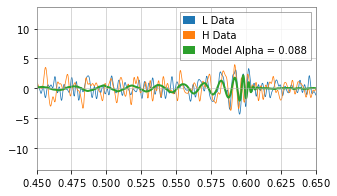

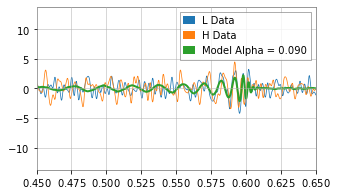

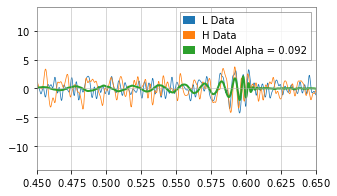

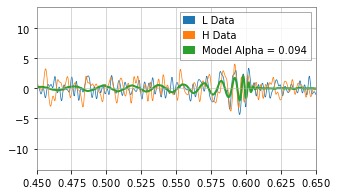

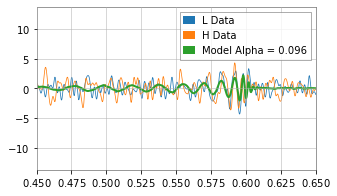

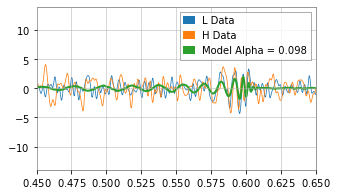

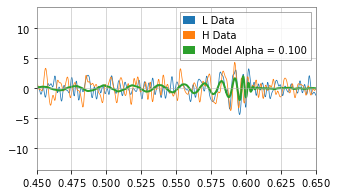

<Figure size 360x216 with 0 Axes>

In [332]:
for i in range(51):
    plt.plot(time[i],strainL[i], label="L Data")
    plt.plot(time[i],strainH[i], label="H Data")
    plt.plot(time[i],model[i], label="Model Alpha = %.3f" % alphas[i], linewidth=2)
    plt.legend(loc="best")
    plt.xlim(0.45,0.65)
    plt.figure()

Maximum at 1167559934.0952 with SNR = 11.2, 
Done it for alpha=0.00000
Maximum at 1167559936.6951 with SNR = 7.4, 
Done it for alpha=0.05000
Maximum at 1167559936.7263 with SNR = 3.9, 
Done it for alpha=1.00000


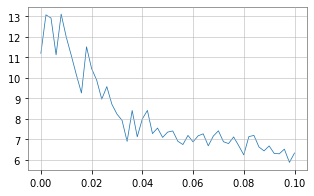

In [333]:
timei, strainLi, strainHi, modeli, SNRi = alphiser(0.0)
timej, strainLj, strainHj, modelj, SNRj = alphiser(0.05)
timek, strainLk, strainHk, modelk, SNRk = alphiser(1)

plt.plot(alphas,SNR)
#plt.xlim(0.005,0.09)

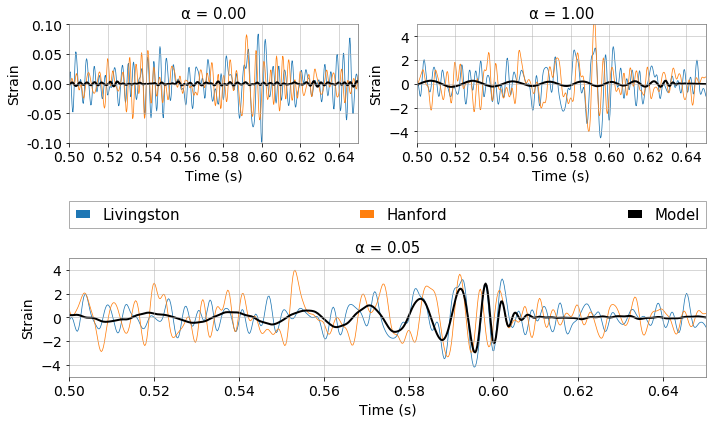

In [409]:
plt.figure(figsize=(10,6))
ax3 = plt.subplot(222)
ax3.plot(timek, strainLk, '-', label="Livingston")
ax3.plot(timek, strainHk, '-', label="Hanford")
ax3.plot(timek, modelk, 'k-', label="Model", linewidth=2)
ax3.set_title("α = 1.00", fontsize=15)
plt.setp(ax3.get_xticklabels(), rotation='horizontal', fontsize=14)
plt.setp(ax3.get_yticklabels(), rotation='horizontal', fontsize=14)
plt.xlim(0.50,0.65)
plt.ylabel('Strain', fontsize=14)
plt.xlabel('Time (s)', fontsize=14)
plt.ylim(-5,5)


ax1 = plt.subplot(212)
ax1.plot(timej, strainLj, '-', label="Livingston")
ax1.plot(timej, strainHj, '-', label="Hanford")
ax1.plot(timej, modelj, 'k-', label="Model", linewidth=2)
ax1.set_title("α = 0.05", fontsize=15)
ax1.legend(bbox_to_anchor=(0., 1.25, 1., .102), loc='lower left',
           ncol=3, mode="expand", borderaxespad=0., fontsize=15)
plt.setp(ax1.get_xticklabels(), rotation='horizontal', fontsize=14)
plt.setp(ax1.get_yticklabels(), rotation='horizontal', fontsize=14)
plt.ylabel('Strain', fontsize=14)
plt.xlabel('Time (s)', fontsize=14)
plt.ylim(-5,5)

plt.xlim(0.50,0.65)

ax2 = plt.subplot(221)
ax2.plot(timei, strainLi, '-', label="Livingston")
ax2.plot(timei, strainHi, '-', label="Hanford")
ax2.plot(timei, modeli, 'k-', label="Model", linewidth=2)
plt.setp(ax2.get_xticklabels(), rotation='horizontal', fontsize=14)
plt.setp(ax2.get_yticklabels(), rotation='horizontal', fontsize=14)

ax2.get_yaxis().set_major_formatter(matplotlib.ticker.FuncFormatter(lambda x, p: "%.2f" % x))

plt.ylabel('Strain', fontsize=14)
plt.xlabel('Time (s)', fontsize=14)
plt.ylim(-0.1,0.1)
ax2.set_title("α = 0.00", fontsize=15)

plt.xlim(0.50,0.65)
plt.tight_layout()

plt.savefig('subplots.png')

In [ ]:
timewhole=[]
strainLwhole=[]
strainHwhole=[]
modelwhole=[]
SNRwhole=[]
alphaswhole=np.linspace(0,1.0,51)


for i in range(51):
    start_time=timone.time()
    answerwhole=alphiser(alphaswhole[i])
    timewhole.append(answerwhole[0])
    strainLwhole.append(answerwhole[1])
    strainHwhole.append(answerwhole[2])
    modelwhole.append(answerwhole[3])
    SNRwhole.append(answerwhole[4])

/cvmfs/ligo-containers.opensciencegrid.org/lscsoft/conda/latest/envs/ligo-py37/lib/python3.7/site-packages/ipykernel_launcher.py:7: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
  import sys


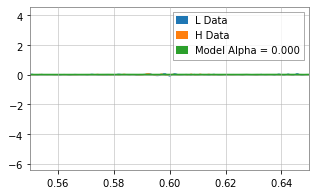

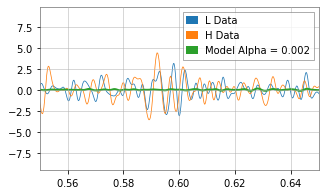

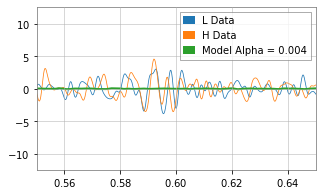

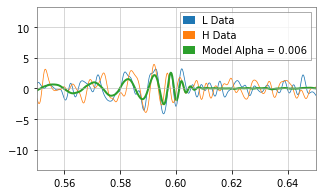

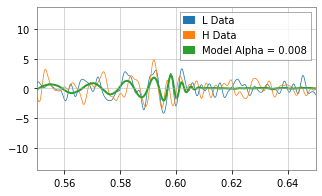

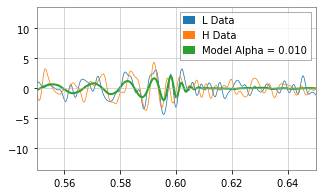

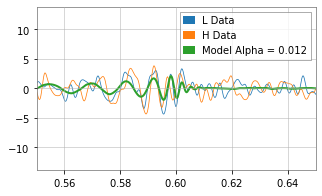

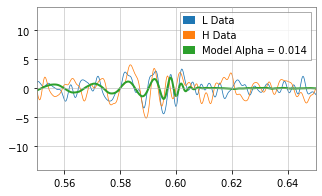

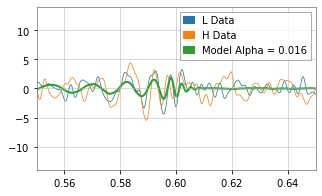

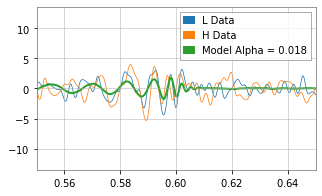

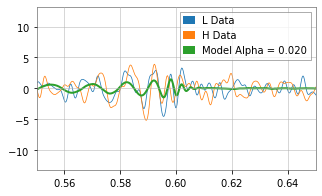

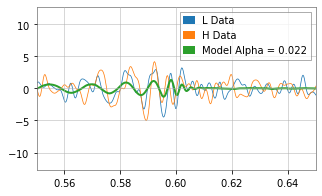

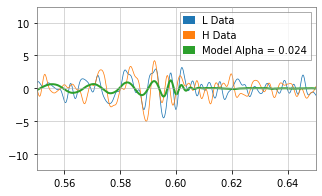

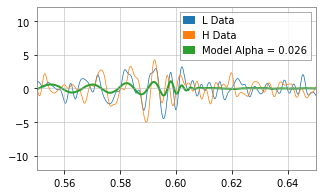

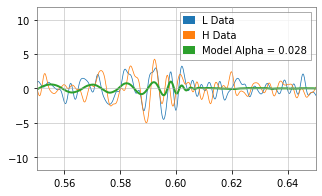

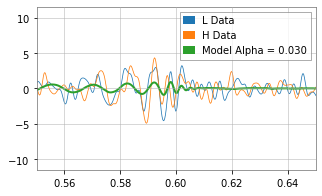

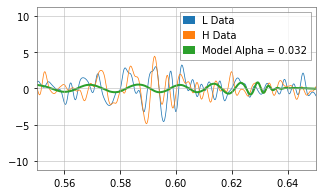

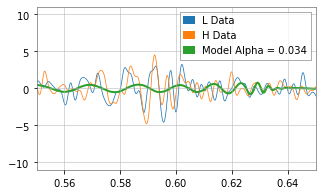

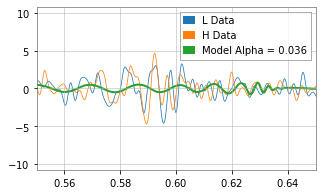

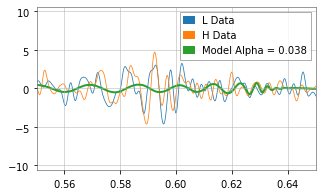

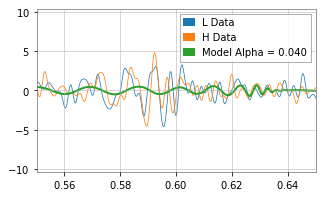

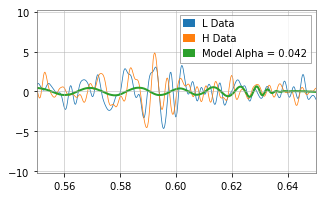

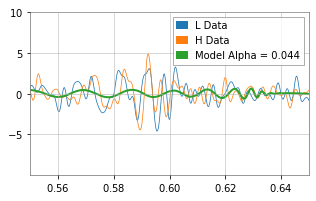

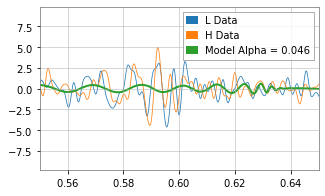

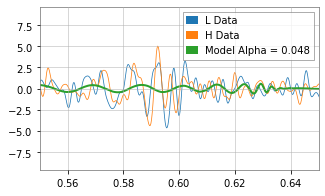

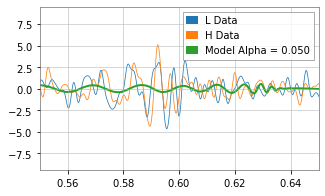

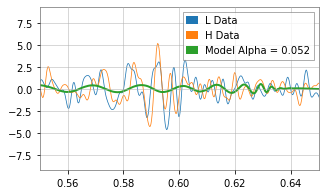

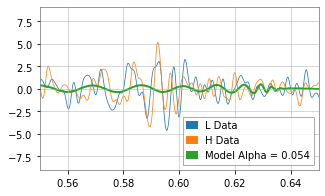

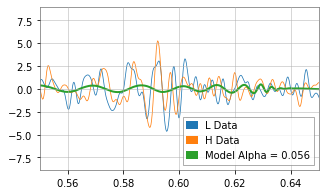

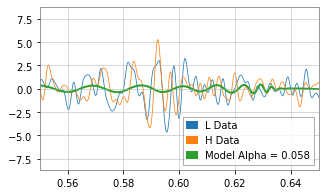

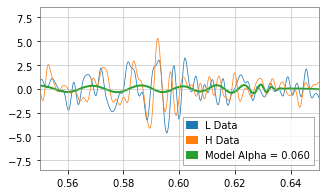

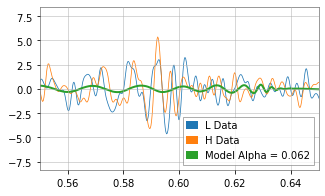

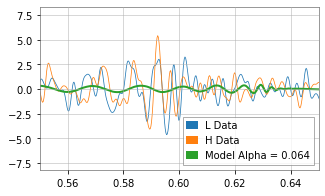

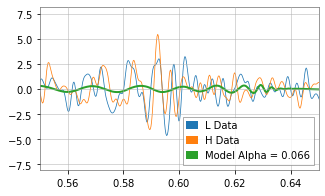

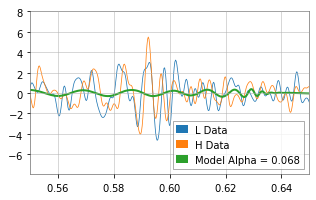

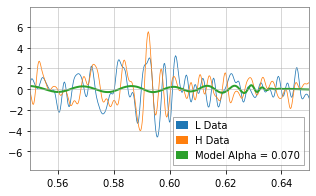

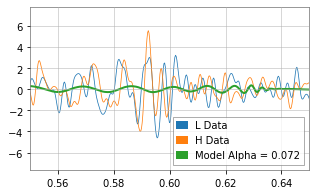

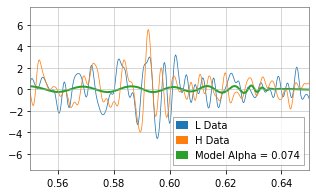

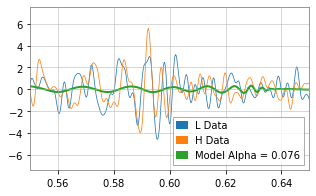

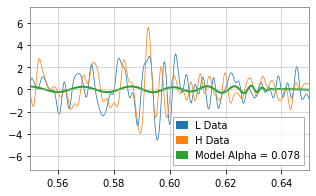

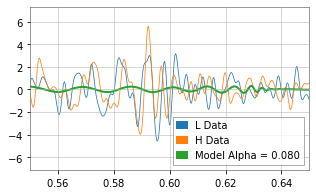

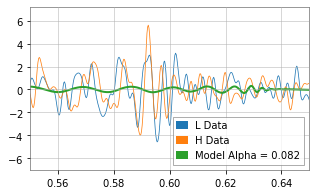

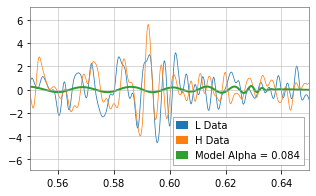

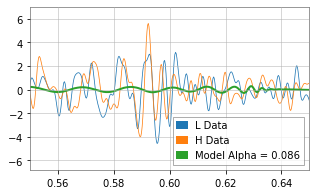

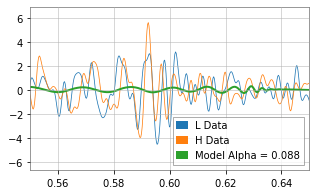

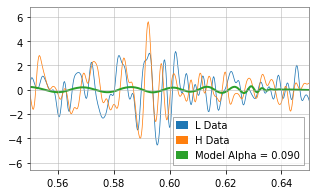

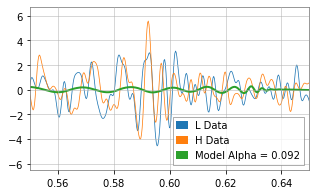

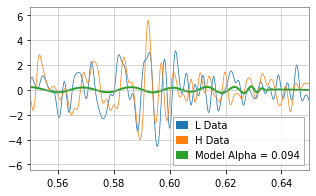

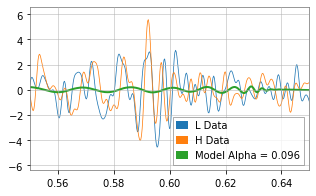

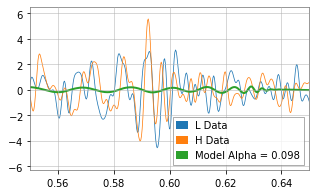

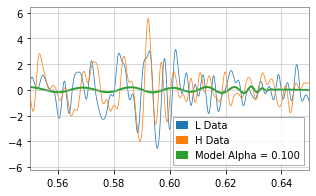

<Figure size 360x216 with 0 Axes>

In [318]:
for i in range(51):
    plt.plot(timewhole[i],strainLwhole[i], label="L Data")
    plt.plot(timewhole[i],strainHwhole[i], label="H Data")
    plt.plot(timewhole[i],modelwhole[i], label="Model Alpha = %.3f" % alphas[i], linewidth=2)
    plt.legend(loc="best")
    plt.xlim(0.55,0.65)
    plt.figure()

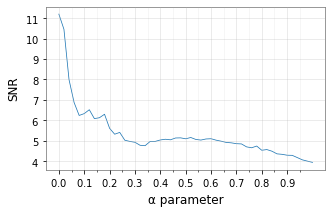

In [304]:
fig = plt.figure()
ax = fig.add_subplot(1, 1, 1)

# Major ticks every 20, minor ticks every 5
majorx_ticks = np.arange(0, 1, 0.1)
minorx_ticks = np.arange(0, 1, 0.05)

majory_ticks = np.arange(0, 15, 5.0)
minory_ticks = np.arange(0, 15, 1.0)

ax.set_xticks(majorx_ticks)
ax.set_xticks(minorx_ticks, minor=True)
#ax.set_yticks(majory_ticks)
#ax.set_yticks(minory_ticks, minor=True)

# And a corresponding grid
ax.grid(which='both')

# Or if you want different settings for the grids:
ax.grid(which='minor', alpha=0.2)
ax.grid(which='major', alpha=0.5)


plt.plot(alphaswhole,SNRwhole)
plt.ylabel("SNR")
plt.xlabel("α parameter")

plt.savefig('alphaiep.png')

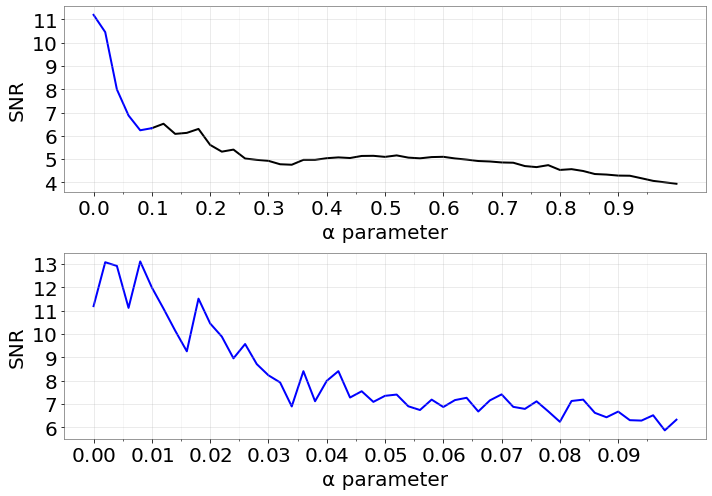

In [379]:
#alphaswhole=np.linspace(0,1.0,21)

plt.figure(figsize=(10,7))

axsm = plt.subplot(212)

# Major ticks every 20, minor ticks every 5
majorx_ticks_sm = np.arange(0, 0.1, 0.01)
minorx_ticks_sm = np.arange(0, 0.1, 0.005)

majory_ticks_sm = np.arange(0, 15, 5.0)
minory_ticks_sm = np.arange(0, 15, 1.0)

axsm.set_xticks(majorx_ticks_sm)
axsm.set_xticks(minorx_ticks_sm, minor=True)

axsm.grid(which='both')

axsm.grid(which='minor', alpha=0.2)
axsm.grid(which='major', alpha=0.5)


plt.plot(alphas,SNR, 'b', linewidth=2)
plt.ylabel("SNR", fontsize=20)
plt.xlabel("α parameter", fontsize=20)
plt.savefig('alphaie.png')


axlg = plt.subplot(211)

# Major ticks every 20, minor ticks every 5
majorx_ticks_lg = np.arange(0, 1, 0.1)
minorx_ticks_lg = np.arange(0, 1, 0.05)

majory_ticks_lg = np.arange(0, 15, 5.0)
minory_ticks_lg = np.arange(0, 15, 1.0)

axlg.set_xticks(majorx_ticks_lg)
axlg.set_xticks(minorx_ticks_lg, minor=True)

axlg.grid(which='both')

axlg.grid(which='minor', alpha=0.2)
axlg.grid(which='major', alpha=0.5)


plt.plot(alphaswhole[5:],SNRwhole[5:], 'k', linewidth=2)
plt.plot(alphaswhole[:6],SNRwhole[:6], 'b', linewidth=2)
plt.ylabel("SNR", fontsize=20)
plt.setp(axlg.get_xticklabels(), rotation='horizontal', fontsize=20)
plt.setp(axlg.get_yticklabels(), rotation='horizontal', fontsize=20)
plt.setp(axsm.get_xticklabels(), rotation='horizontal', fontsize=20)
plt.setp(axsm.get_yticklabels(), rotation='horizontal', fontsize=20)
plt.xlabel("α parameter", fontsize=20)
plt.tight_layout()
plt.savefig('alphaip.png')